In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.learning_utils import get_learner
from jaxl.utils import parse_dict

import json
import numpy as np
import os

from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

In [2]:
base_dir = "/Users/chanb/research/personal/jaxl/jaxl"
# learner_path = os.path.join(
#     base_dir,
#     "logs/icl-linear_sgd-full_context_20/gpt-no_enc-08-21-23_07_36_59-971a17db-73ed-4f77-b463-5887644e3385"
# )
# learner_path = os.path.join(
#     base_dir,
#     "logs/icl-linear_sgd-full_context_20/gpt-pos_enc-08-21-23_07_36_58-5473978c-10db-433b-889b-f136405d7a7e"
# )
learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-linear_sgd-full_context_20/gpt-low_embed-08-23-23_07_20_59-0876bed6-f8b6-47f6-ab3a-7bba4b2b4308"
test_dataset_seed = 999

In [3]:
config_path = os.path.join(learner_path, "config.json")
with open(config_path, "r") as f:
    config_dict = json.load(f)
    config = parse_dict(config_dict)
    
learner = get_learner(
    config.learner_config, config.model_config, config.optimizer_config
)

checkpoint_manager = CheckpointManager(
    os.path.join(learner_path, "models"),
    PyTreeCheckpointer(),
)

params = checkpoint_manager.restore(checkpoint_manager.latest_step())
params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()
model = learner._model

In [4]:
config.learner_config.dataset_config

namespace(dataset_name='multitask_toy_regression',
          dataset_kwargs=namespace(basis='polynomial',
                                   degree=1,
                                   num_sequences=100000,
                                   sequence_length=41,
                                   noise=0.1,
                                   params_bound=[-10.0, 10.0],
                                   val_frac=0.0005),
          dataset_wrapper=namespace(type='ContextDataset',
                                    kwargs=namespace(context_len=20)))

In [5]:
sequence_len = 80
test_config = vars(config.learner_config.dataset_config)
test_config["dataset_kwargs"] = vars(test_config["dataset_kwargs"])
test_config["dataset_kwargs"]["sequence_length"] = sequence_len + 1
test_config["dataset_kwargs"]["params_bound"] = [-0.5, 0.5]
test_config["dataset_kwargs"]["inputs_range"] = [-1.0, 1.0]
test_config = parse_dict(test_config)

In [6]:
test_dataset = get_dataset(test_config, seed=test_dataset_seed)

In [7]:
def get_result(dataset, sequence_length):
    context_inputs, context_outputs, queries, outputs = [], [], [], []
    for seq_i in range(sequence_length):
        context_input, context_output, query, output = dataset[seq_i]
        context_inputs.append(context_input)
        context_outputs.append(context_output)
        queries.append(query)
        outputs.append(output)
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)
    queries = np.stack(queries)
    outputs = np.stack(outputs)

    preds, _ = model.forward(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries,
        {
            CONST_CONTEXT_INPUT: context_inputs,
            CONST_CONTEXT_OUTPUT: context_outputs,
        }
    )
    return queries, preds, outputs, context_inputs, context_outputs

In [8]:
def mse(preds, outputs):
    return np.mean((preds - outputs) ** 2)

In [9]:
queries, preds, outputs, context_inputs, context_outputs = get_result(
    test_dataset,
    sequence_length=sequence_len
)
loss = mse(preds, outputs)
print(queries.shape, preds.shape, outputs.shape)

(80, 1, 1) (80, 1) (80, 1)


In [10]:
loss

Array(0.07005423, dtype=float32)

# Basic Prediction Result

In [11]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'output')

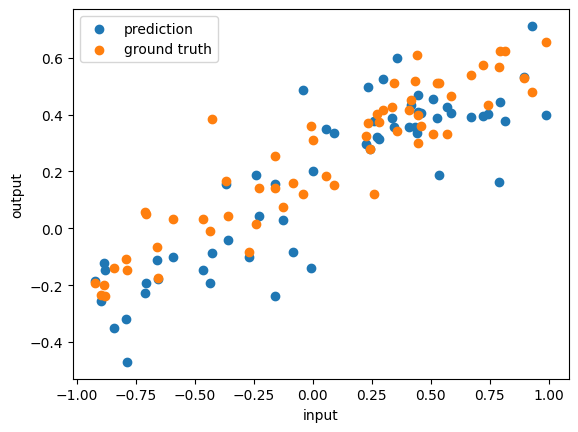

In [12]:
context_len = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len
plt.scatter(queries[context_len:], preds[context_len:], label="prediction")
plt.scatter(queries[context_len:], outputs[context_len:], label="ground truth")
plt.legend()
plt.xlabel("input")
plt.ylabel("output")

In [13]:
def get_latent(dataset, sequence_length):
    context_inputs, context_outputs, queries, outputs = [], [], [], []
    for seq_i in range(sequence_length):
        context_input, context_output, query, output = dataset[seq_i]
        context_inputs.append(context_input)
        context_outputs.append(context_output)
        queries.append(query)
        outputs.append(output)
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)
    queries = np.stack(queries)
    outputs = np.stack(outputs)

    latent, _ = model.get_latent(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries,
        {
            CONST_CONTEXT_INPUT: context_inputs,
            CONST_CONTEXT_OUTPUT: context_outputs,
        }
    )
    return queries, latent

In [14]:
queries, latents = get_latent(
    test_dataset,
    sequence_length=sequence_len
)
print(queries.shape, latents.shape)

(80, 1, 1) (80, 41, 10)


In [15]:
from jaxl.utils import l2_norm

In [16]:
for latent in latents:
    print(latent)

[[ 1.6022879  -0.7576801   1.445726    1.2671884   0.43627927  0.08423992
  -2.4136374  -0.7240866   1.0311381   2.2541876 ]
 [ 0.13252726  0.8629671   2.1009402   1.49195     1.5207973   0.18690749
  -3.254626   -0.18349804 -2.0535626   0.9878681 ]
 [ 1.2888497  -0.36810032  2.3018556   1.4470551   0.84165853 -0.32050943
  -2.9523857  -0.21737325 -1.4956205   2.7456288 ]
 [ 0.08004343  1.0156243   2.0582106   1.4043082   1.3098099   0.2705939
  -3.2606435  -0.1438145  -2.0863285   0.8334628 ]
 [ 0.85956985 -0.19489421  2.385997    1.5187036   0.5247422  -0.08576972
  -3.166545   -0.19361387 -1.425804    2.6206763 ]
 [-0.15304586  1.1141376   2.0262868   1.3700987   1.0506835   0.4155801
  -3.3077796  -0.1132264  -1.9929404   0.76166403]
 [ 0.8058983  -0.280825    2.283791    1.5565372   0.39509326  0.04727355
  -3.1699347  -0.18910594 -1.3018434   2.700131  ]
 [-0.10951386  1.1227787   1.8992895   1.2617809   0.96208405  0.5504861
  -3.4247868  -0.09462756 -1.9204022   0.9113036 ]
 [ 